# Purpose

Weighter is designed to be a hacky weight tracking app using Slack as a frontend and Google Sheets as a database! 
Weights are entered through a Slack Channel, stored in a Google Sheet, and reported back to users through Slack. Users will have the option to view various stats and graphs by sending different slack messages. 

Weighter also features additive modeling forecasts using the Facebook Prophet library. 

## Setup Libraries and Access to the Google Sheet

In [262]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# fbprophet for additive models
import fbprophet

# gspread for Google Sheets access
import gspread

# slacker for interacting with Slack
from slacker import Slacker

# oauth2client for authorizing access to Google Sheets
from oauth2client.service_account import ServiceAccountCredentials

import os

In [263]:
# matplotlib for plotting in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

### Google Sheet Access

The json file is the credentials for accessing the google sheet generated from the Google Developers API. To access a specific sheet, you need to share the sheet with the email address in the json file. 

In [264]:
# google sheets access
scope = ['https://spreadsheets.google.com/feeds']

# Use local stored credentials in json file
# make sure to first share the sheet with the email in the json file
credentials = ServiceAccountCredentials.from_json_keyfile_name('C:/Users/Will Koehrsen/Desktop/weighter-2038ffb4e5a6.json', scope)

# Authorize access
gc = gspread.authorize(credentials);

INFO:oauth2client.client:Refreshing access_token


## Set up Slack Access

In [265]:
# Slack api key is stored as text file
with open('C:/Users/Will Koehrsen/Desktop/slack_api.txt', 'r') as f:
    slack_api_key = f.read()

In [266]:
slack = Slacker(slack_api_key)

In [267]:
slack.chat.post_message('#test_python', 'Hello Fellow Slackers')

### Open the sheet and convert to a pandas dataframe

In [268]:
# Open the sheet, need to share the sheet with email specified in json file
gsheet = gc.open('Auto Weight Challenge').sheet1

# List of lists with each row in the sheet as a list
weight_lists = gsheet.get_all_values()

# Headers are the first list
# Pop returns the element (list in this case) and removes it from the list
headers = weight_lists.pop(0)

# Convert list of lists to a dataframe with specified column header
weights = pd.DataFrame(weight_lists, columns=headers)

# Record column should be a boolean
weights['Record'] = weights['Record'].astype(bool)

# Name column is a string
weights['Name'] = weights['Name'].astype(str)

# Convert dates to datetime, then set as index, then set the time zone
weights['Date'] = pd.to_datetime(weights['Date'], unit='s')
weights  = weights.set_index('Date', drop = True).tz_localize(tz='US/Eastern')

In [269]:
weights.head()

,Name,Entry,Record,Change,Pct_change
Date,,,,,
2017-08-18 00:00:00-04:00,koehrcl,235.2,True,0,0.00
2017-08-19 00:00:00-04:00,koehrcl,235.6,True,-0.4,-0.17
2017-08-20 00:00:00-04:00,koehrcl,233,True,2.2,0.94
2017-08-21 00:00:00-04:00,koehrcl,232.6,True,2.6,1.11
2017-08-22 00:00:00-04:00,koehrcl,234.4,True,0.8,0.34


In [270]:
weights.tail()

,Name,Entry,Record,Change,Pct_change
Date,,,,,
2018-01-19 15:30:25-05:00,willkoehrsen,137.3,False,10.7,8.45
2018-01-19 18:11:49-05:00,fletcher,188.4,False,3.8,2.06
2018-01-20 15:39:12-05:00,willkoehrsen,137,False,10.4,8.21
2018-01-20 15:49:52-05:00,koehrcl,220.4,False,14.8,6.29
2018-01-20 18:09:57-05:00,fletcher,188.6,False,4,2.17


+ Date is the index (in Eastern time here)
+ Name is the slack username
+ Entry is either weight or a string to display results
+ Record is whether or not the entry has been processed by weighter

# Weighter Class

The class will include a number of different methods for analyzing the data and graphing results. These results can then be sent back to Slack depending on the message entered by the user.

In [271]:
class Weighter():
    
    """
    When weighter is initialized, we need to convert the usernames,
    get a dictionary of the unrecorded entries, construct a dictionary
    of the actions to take, and make sure all data is formatted correctly
    """
    
    def __init__(self, weights):
        
        # Weights is a dataframe
        self.weights = weights.copy()
        
        # Users is a list of the unique users in the data
        self.users = list(set(self.weights['Name']))
        
        correct_names = []
        # Name Changes
        for user in self.weights['Name']:
            
            # Have to hardcode in name Changes
            if user == 'koehrcl':
                correct_names.append('Craig')
            elif user == 'willkoehrsen':
                correct_names.append('Will')
            elif user == 'fletcher':
                correct_names.append('Fletcher')
            
            # Currently do not handle new users
            else:
                print('New User Detected')
                return
            
        self.weights['Name'] = correct_names
        
        # Users is a list of the unique users in the data
        self.users = list(set(self.weights['Name']))
        
        # Create a dataframe of the unrecorded entries
        self.unrecorded = self.weights[self.weights['Record'] != True]
        
        # Process the unrecorded entries
        self.process_unrecorded()
        
        # The remaning entries will all be weights
        self.weights['Entry'] = [float(weight) for weight in self.weights['Entry']]
        self.weights['Change'] = [float(change) for change in self.weights['Change']]
        self.weights['Pct_change'] = [float(pct_change) for pct_change in self.weights['Pct_change']]
        
        # Build the user dictionary
        self.build_user_dict()
        
       # self.calculate_columns()
        
    """ 
    Constructs a dictionary for each user with critical information
    This forms the basis for the summarize function
    """
    
    def build_user_dict(self):
        
        user_dict = {}
        
        user_goals = {'Craig': 215.0, 'Fletcher': 200.0, 'Will': 155.0}
        user_colors = {'Craig': 'forestgreen', 'Fletcher': 'navy', 'Will': 'darkred'}
        
        for i, user in enumerate(self.users):
            
            user_weights = self.weights[self.weights['Name'] == user]
            goal = user_goals.get(user)

            start_weight = user_weights.ix[min(user_weights.index), 'Entry']   
            start_date = min(user_weights.index)
            
            # Find minimum weight and date on which it occurs
            min_weight =  min(user_weights['Entry'])
            min_weight_date = ((user_weights[user_weights['Entry'] == min_weight].index)[0])
            
            # Find maximum weight and date on which it occurs
            max_weight = max(user_weights['Entry'])
            max_weight_date = ((user_weights[user_weights['Entry'] == max_weight].index)[0])
            
            most_recent_weight = user_weights.ix[max(user_weights.index), 'Entry']
            
            if goal < start_weight:
                change = start_weight - most_recent_weight
                obj = 'lose'
            elif goal > start_weight:
                change = most_recent_weight - start_weight
                obj = 'gain'
                
            pct_change = 100 * change / start_weight
            
            pct_to_goal = 100 * (change / abs(start_weight - goal) )
            
            # Color for plotting
            user_color = user_colors[user]
            
            user_dict[user] = {'min_weight': min_weight, 'max_weight': max_weight,
                               'min_date': min_weight_date, 'max_date': max_weight_date,
                               'recent': most_recent_weight, 'abs_change': change,
                               'Pct_change': pct_change, 'pct_towards_goal': pct_to_goal,
                               'start_weight': start_weight, 'start_date': start_date,
                               'goal_weight': goal, 'objective': obj, 'color': user_color}
       
        self.user_dict = user_dict
             
    """
    Builds a dictionary of unrecorded entries where each key is the user
    and the value is a list of weights and methods called for by the user.
    This dictionary is saved as the entries attribute of the class.
    """
    
    def process_unrecorded(self):
        
        entries = {name:[] for name in self.users}
        drop = []
        
        for index in self.unrecorded.index:

            entry = self.unrecorded.ix[index, 'Entry']
            user = str(self.unrecorded.ix[index, 'Name'])
            
            # Try and except does not seem like the best way to handle this
            try:
                entry = float(entry)
                entries[user].append(entry)
                
            except:  
                entry = str(entry)
                entries[user].append(entry)
                
                drop.append(index)
                
            self.weights.ix[index, 'Record'] = True
        # Drop the rows which do not contain a weight
        self.weights.drop(drop, axis=0, inplace=True)
        
        # Entries is all of the new entries
        self.entries = entries
        
    """ 
    Iterates through the unrecorded entries and delegates 
    each one to the appropriate method.
    """
    def process_entries(self):
        for user, user_entries in self.entries.items():
            for entry in user_entries:
                if type(entry) == float:
                    self.basic_message(user)
                
                elif entry.lower() == 'summary':
                    self.summary(user)
                    
                elif entry.lower() == 'percent':
                    self.percentage_plot()
                    
                elif entry.lower() == 'history':
                    self.history_plot(user)
                
    """ 
    This method is automatically run for each new weight
    """
    def basic_message(self, user):
    
        # Find information for user, construct message, post message to Slack
        user_info = self.user_dict.get(user)

        message = ("\n{}: Total Weight Change = {:.2f} lbs.\n\n"
                    "Percentage Weight Change = {:.2f}%").format(user, user_info['abs_change'],
                                                     user_info['Pct_change'])

        slack.chat.post_message('#test_python', text=message, username='Weight Challenge Update')
                        
    """ 
    Displays comprehensive stats about the user
    Only run on a summary message in the slack channel
    """
    
    def summary(self, user):
        user_info = self.user_dict.get(user)
        message = ("\n{}, your most recent weight was {:.2f} lbs.\n\n"
                   "Absolute weight Change = {:.2f} lbs, percentage weight Change = {:.2f}%.\n\n"
                   "Minimum weight = {:.2f} lbs on {} and maximum weight = {:.2f} lbs on {}.\n\n"
                   "Your goal weight = {:.2f} lbs. and you are {:.2f}% of the way there.\n\n"
                   "You started at {:.2f} lbs on {}. Congratulations on the progress!").format(user, 
                     user_info['recent'], user_info['abs_change'], user_info['Pct_change'], 
                     user_info['min_weight'], str(user_info['min_date'].date()),
                     user_info['max_weight'], str(user_info['max_date'].date()),
                     user_info['goal_weight'], user_info['pct_towards_goal'],                                                       
                     user_info['start_weight'], str(user_info['start_date'].date()))
        
        slack.chat.post_message('#test_python', text=message, username='%s Summary' % user)
        
    """ 
    Adds the change and percentage change columns to the self.weights df
    """
#     def calculate_columns(self):
        
#         self.weights = self.weights.sort_values('Name')
#         self.weights['Change'] = 0
#         self.weights['Pct_change'] = 0
#         self.weights.reset_index(level=0, inplace = True)
        
#         for index in self.weights.index:
#             user = self.weights.ix[index, 'Name']
#             weight = self.weights.ix[index, 'Entry']
#             start_weight = self.user_dict[user]['start_weight']
#             objective = self.user_dict[user]['objective']
            
#             if objective == 'lose':
                
#                 self.weights.ix[index, 'Change'] = start_weight - weight
#                 self.weights.ix[index, 'Pct_change'] = 100 * (start_weight - weight) / start_weight
                
#             elif objective == 'gain':
#                 self.weights.ix[index, 'Change'] = weight - start_weight
#                 self.weights.ix[index, 'Pct_change'] = 100 * (weight - start_weight) / start_weight

#         self.weights.set_index('Date', drop=True, inplace=True)
        
    @staticmethod
    def reset_plot():
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
    def percentage_plot(self):
        
        self.reset_plot()
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10,8))

        for i, user in enumerate(weighter.users):
            
            user_color = self.user_dict[user]['color']

            # Select the user and order dataframe by date
            df = self.weights[self.weights['Name'] == user]
            df.sort_index(inplace=True)
            
            # List is used for fitting polynomial
            xvalues = list(range(len(df)))

            # Create a polynomial fit
            z = np.polyfit(xvalues, df['Pct_change'], deg=6)

            # Create a function from the fit
            p = np.poly1d(z)

            # Map the x values to y values
            fit_data = p(xvalues)

            # Plot the actual points and the fit
            plt.plot(df.index, df['Pct_change'], 'o', color = user_color, label = '%s' % user)
            plt.plot(df.index, fit_data, '-', color = user_color, linewidth = 5, label = '%s' % user)


        # Plot formatting
        plt.xlabel('Date'); plt.ylabel('Percentage Change')
        plt.title('Percentage Changes')
        plt.grid(color='k', alpha=0.4)
        plt.legend(prop={'size':14})
        plt.savefig(fname='percentage_plot.png');
        
        slack.files.upload('percentage_plot.png', channels='#test_python')
        
        os.remove('percentage_plot.png')
        
    def history_plot(self, user):
        
        self.reset_plot()
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10, 8))
        
        df = self.weights[self.weights['Name'] == user]
        df.sort_index(inplace=True) 
        user_color = self.user_dict[user]['color']
        
        # List is used for fitting polynomial
        xvalues = list(range(len(df)))

        # Create a polynomial fit
        z = np.polyfit(xvalues, df['Entry'], deg=6)

        # Create a function from the fit
        p = np.poly1d(z)

        # Map the x values to y values
        fit_data = p(xvalues)

        # Make a simple plot and upload to slack
        plt.plot(df.index, df['Entry'], 'ko', ms = 8, label = 'Observed')
        plt.plot(df.index, fit_data, '-', color = user_color, linewidth = 5, label = 'Smooth Fit')
        plt.xlabel('Date'); plt.ylabel('Weight (lbs)'); plt.title('%s Weight History' % user)
        plt.legend(prop={'size': 14});
        
        plt.savefig(fname='history_plot.png')
        slack.files.upload('history_plot.png', channels='#test_python')
        
        os.remove('history_plot.png')

In [272]:
weighter = Weighter(weights)

In [273]:
update = weighter.weights

In [274]:
update.tail(10)

,Name,Entry,Record,Change,Pct_change
Date,,,,,
2018-01-17 15:55:47-05:00,Fletcher,188.0,True,3.4,1.84
2018-01-18 19:46:11-05:00,Will,137.8,True,11.2,8.85
2018-01-18 20:21:28-05:00,Craig,220.2,True,15.0,6.38
2018-01-18 21:55:45-05:00,Fletcher,188.6,True,4.0,2.17
2018-01-19 14:34:56-05:00,Craig,221.1,True,14.1,5.99
2018-01-19 15:30:25-05:00,Will,137.3,True,10.7,8.45
2018-01-19 18:11:49-05:00,Fletcher,188.4,True,3.8,2.06
2018-01-20 15:39:12-05:00,Will,137.0,True,10.4,8.21
2018-01-20 15:49:52-05:00,Craig,220.4,True,14.8,6.29


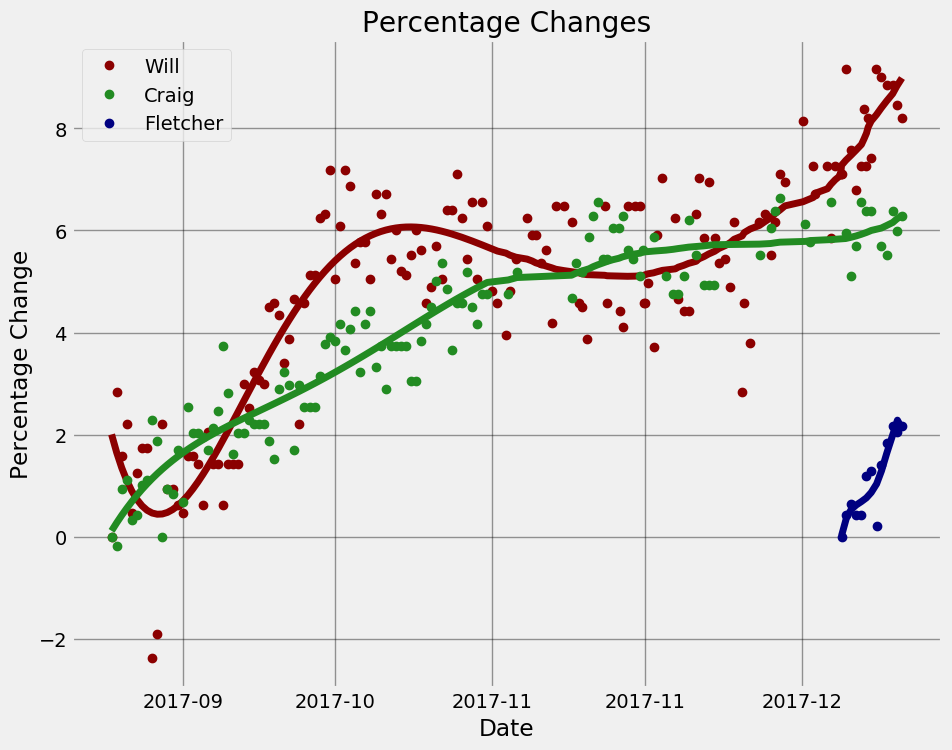

In [275]:
weighter.percentage_plot()

In [260]:
gsheet.update_cell(row= 1, col = 6, val = 0)

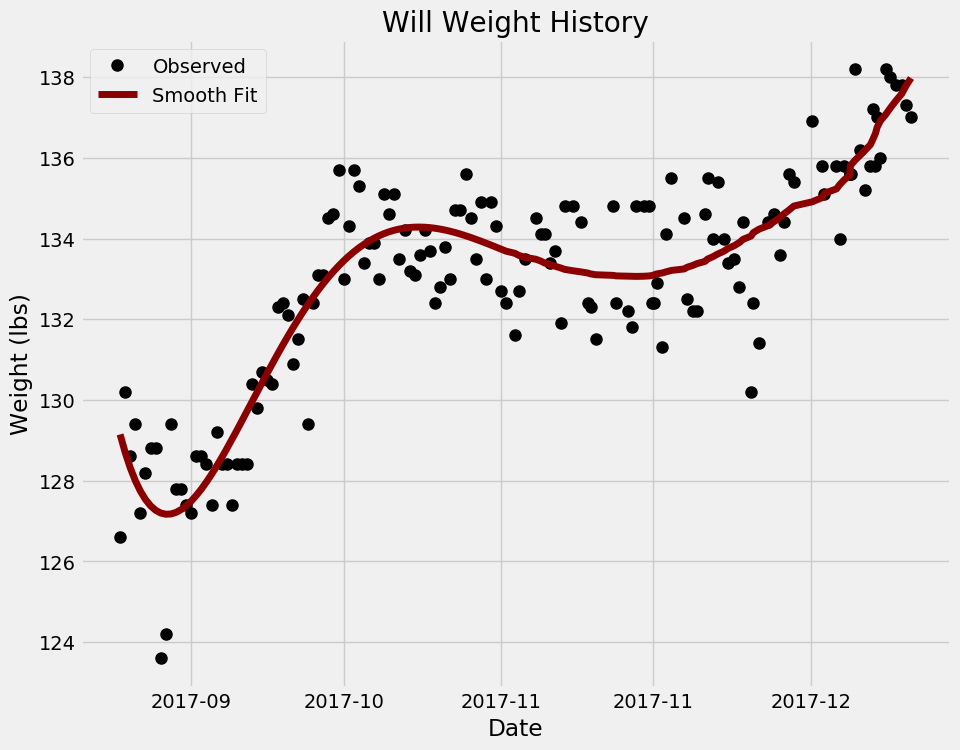

In [242]:
weighter.history_plot('Will')

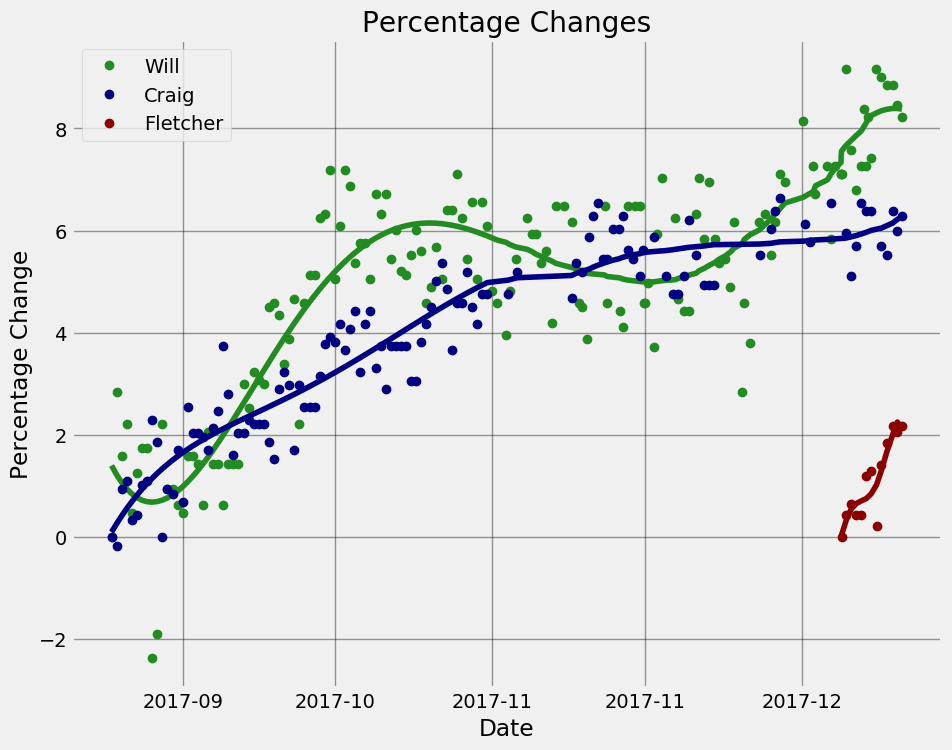

In [229]:
weighter.percentage_plot()

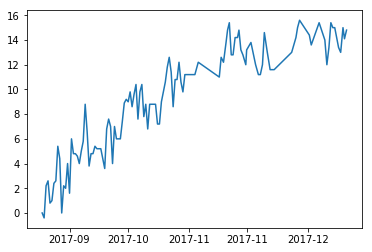

In [159]:
weights_craig = weighter.weights[weighter.weights['Name'] == 'Craig']
weights_craig.sort_index(inplace=True)
plt.plot(weights_craig.index, weights_craig['Change']);

In [160]:
we = weighter.weights

In [215]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

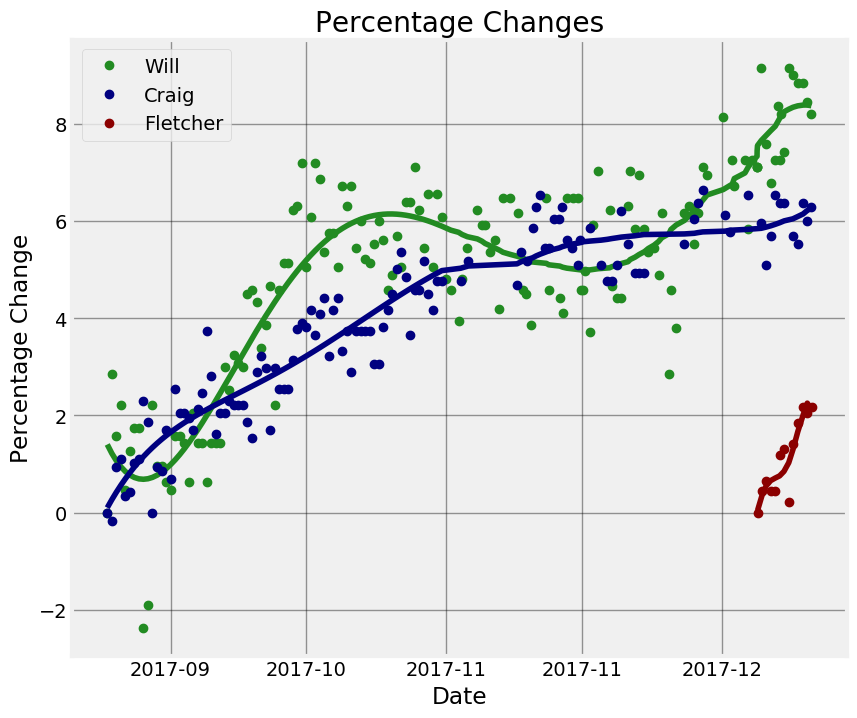

In [216]:
plt.figure(figsize=(10,8))
colors = ['forestgreen', 'navy', 'darkred']
plt.style.use('fivethirtyeight')
for i, user in enumerate(weighter.users):
    
    
    df = we[we['Name'] == user]
    df.sort_index(inplace=True)
    xvalues = list(range(len(df)))
    
    # Create a polynomial fit
    z = np.polyfit(xvalues, df['Pct_change'], deg=5)
    
    # Create a function from the fit
    p = np.poly1d(z)
    
    # Map the x values to y values
    fit_data = p(xvalues)
    
    # Plot the actual points and the fit
    plt.plot(df.index, df['Pct_change'], 'o', color = colors[i], label = '%s' % user)
    plt.plot(df.index, fit_data, '-', color = colors[i], linewidth = 4, label = '%s' % user)
    
    

plt.xlabel('Date'); plt.ylabel('Percentage Change')
plt.title('Percentage Changes')
plt.grid(color='k', alpha=0.4)
plt.legend(prop={'size':14})
plt.show()

[  1.03781409e-14   2.00000000e+00   4.00000000e+00   6.00000000e+00
   8.00000000e+00   1.00000000e+01   1.20000000e+01   1.40000000e+01
   1.60000000e+01   1.80000000e+01   2.00000000e+01   2.20000000e+01
   2.40000000e+01   2.60000000e+01   2.80000000e+01   3.00000000e+01
   3.20000000e+01   3.40000000e+01   3.60000000e+01   3.80000000e+01
   4.00000000e+01   4.20000000e+01   4.40000000e+01   4.60000000e+01
   4.80000000e+01   5.00000000e+01   5.20000000e+01   5.40000000e+01
   5.60000000e+01   5.80000000e+01   6.00000000e+01   6.20000000e+01
   6.40000000e+01   6.60000000e+01   6.80000000e+01   7.00000000e+01
   7.20000000e+01   7.40000000e+01   7.60000000e+01   7.80000000e+01
   8.00000000e+01   8.20000000e+01   8.40000000e+01   8.60000000e+01
   8.80000000e+01   9.00000000e+01   9.20000000e+01   9.40000000e+01
   9.60000000e+01   9.80000000e+01   1.00000000e+02   1.02000000e+02
   1.04000000e+02   1.06000000e+02   1.08000000e+02   1.10000000e+02
   1.12000000e+02   1.14000000e+02

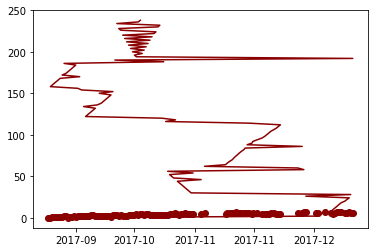

In [170]:
from scipy.optimize import curve_fit

In [178]:
info, z = curve_fit(func, list(range(len(df.index))), df['Pct_change'], maxfev = 10000)

In [184]:
z = np.polyfit(list(range(len(df.index))), df['Pct_change'], deg = 4)

In [187]:
p = np.poly1d(z)
p(df['Pct_change'])

array([  2.80135389e-04,   2.14840875e-01,   2.99539247e-01,
         2.14840875e-01,   2.14840875e-01,   4.56766881e-01,
         4.80196888e-01,   1.15580374e-01,   5.01324718e-01,
         5.65790132e-01,   5.97036503e-01,   5.87980312e-01,
         5.97036503e-01])

In [107]:
Change,Pct_change = weighter.calculate_columns()

In [114]:
Change = np.array(Change)

In [120]:
Change = Change.reshape((-1, ))

In [118]:
weighter.weights['Change'] = Change

ValueError: Length of values does not match length of index

In [104]:
weighter.weights

,Name,Entry,Record,change_x,pct_change_x,change_y,pct_change_y,change,pct_change
0,Craig,235.2,True,NaN,NaN,0.0,234.200000,NaN,NaN
1,Craig,235.2,True,NaN,NaN,0.0,234.200000,NaN,NaN
2,Craig,220.8,True,NaN,NaN,14.4,234.261224,NaN,NaN
3,Craig,221.6,True,NaN,NaN,13.6,234.257823,NaN,NaN
4,Craig,219.8,True,NaN,NaN,15.4,234.265476,NaN,NaN
5,Craig,219.8,True,NaN,NaN,15.4,234.265476,NaN,NaN
6,Craig,219.8,True,NaN,NaN,15.4,234.265476,NaN,NaN
7,Craig,221.2,True,NaN,NaN,14.0,234.259524,NaN,NaN
8,Craig,223.2,True,NaN,NaN,12.0,234.251020,NaN,NaN
9,Craig,223.2,True,NaN,NaN,12.0,234.251020,NaN,NaN


In [64]:
flat = [j for entry in Change for j in entry]

In [65]:
flat

[Date
 2017-10-16 00:00:00-04:00     7.0
 2017-10-17 00:00:00-04:00     7.6
 2017-10-18 00:00:00-04:00     7.1
 2017-10-19 00:00:00-04:00     5.8
 2017-10-20 00:00:00-04:00     6.2
 2017-10-21 00:00:00-04:00     7.2
 2017-10-22 00:00:00-04:00     6.4
 2017-10-24 00:00:00-04:00     8.1
 2017-10-31 00:00:00-04:00     7.7
 2017-10-25 00:00:00-04:00     9.0
 2017-10-26 00:00:00-04:00     7.9
 2017-10-27 00:00:00-04:00     6.9
 2017-10-28 00:00:00-04:00     8.3
 2017-10-29 00:00:00-04:00     6.4
 2017-10-30 00:00:00-04:00     8.3
 2017-10-13 00:00:00-04:00     7.6
 2017-11-02 00:00:00-04:00     5.8
 2017-10-09 00:00:00-04:00     8.5
 2017-11-03 16:28:37-04:00     5.0
 2017-11-01 00:00:00-04:00     6.1
 2017-10-12 00:00:00-04:00     6.9
 2017-11-04 11:02:39-04:00     6.1
 2017-11-05 13:52:15-05:00     6.9
 2017-10-11 00:00:00-04:00     8.5
 2017-11-07 19:23:04-05:00     7.9
 2017-11-08 19:26:10-05:00     7.5
 2017-11-09 12:10:44-05:00     7.5
 2017-11-10 14:56:29-05:00     6.8
 2017-11-11 15

In [55]:
weighter.weights['Change'] = Change

ValueError: Length of values does not match length of index

In [12]:

weighter.weights.tail()

,Name,Entry,Record
Date,,,
2018-01-19 15:30:25-05:00,Will,137.3,True
2018-01-19 18:11:49-05:00,Fletcher,188.4,True
2018-01-20 15:39:12-05:00,Will,137.0,True
2018-01-20 15:49:52-05:00,Craig,220.4,True
2018-01-20 18:09:57-05:00,Fletcher,188.6,True


In [13]:
weighter.process_entries()

In [14]:
weighter.summary('Craig')

In [ ]:
weighter.summary('Craig')